<a href="https://colab.research.google.com/github/zenAurelius/HRAI3/blob/main/notebooks/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HRAI/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HRAI/data


In [2]:
df = pd.read_csv('pmu2016_os.zip')
df.head()

,aid_cr,rfs_date,rfs_heure,ris_nom,rfi_prix,rfi_distance,rfs_corde,rfs_condSexe,rfi_nbPartants,rfs_hippodrome,...,pff_ord_2,OS_D_MU_pis_cheval_1,OS_D_SG_pis_cheval_1,OS_N_MU_pis_cheval_1,OS_N_SG_pis_cheval_1,OS_D_MU_pis_driver_1,OS_D_SG_pis_driver_1,OS_N_MU_pis_driver_1,OS_N_SG_pis_driver_1,pff_pwin_1
0,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
1,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
2,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
3,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
4,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,1.964295,0.981306,26.964295,8.177963,1.964295,0.981306,26.964295,8.177963,0.5


In [3]:
#SELECTION DES FEATURES ET TARGET
df = df[['rfi_prix','rfi_distance','pfi_chNbPlaces_1','pff_rapportDirect_1','pff_ord_1','pfi_chNbPlaces_2','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df.head()

,rfi_prix,rfi_distance,pfi_chNbPlaces_1,pff_rapportDirect_1,pff_ord_1,pfi_chNbPlaces_2,pff_rapportDirect_2,pff_ord_2,tgf_win_1
0,90000,2100,16,39.0,14.642893,1,10.0,14.642893,0.0
1,90000,2100,16,39.0,14.642893,6,31.0,14.642893,0.0
2,90000,2100,16,39.0,14.642893,1,6.9,14.642893,0.0
3,90000,2100,16,39.0,14.642893,2,8.6,14.642893,0.0
4,90000,2100,16,39.0,14.642893,22,100.0,14.642893,1.0


In [4]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


1136616 training examples
142077 validation examples
142077 test examples


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('tgf_win_1')
  df = {key: np.array(value)[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [17]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [19]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ord_1:', train_features['pff_ord_1'])
print('A batch of targets:', label_batch )


Every feature: ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2', 'tgf_win_1']
A batch of ord_1: tf.Tensor(
[[62.64289603]
 [30.0619021 ]
 [17.26459247]
 [66.88469782]
 [41.80212348]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([0.  0.  0.5 1.  1. ], shape=(5,), dtype=float64)


In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [22]:
photo_count_col = train_features['pfi_chNbPlaces_1']
layer = get_normalization_layer('pfi_chNbPlaces_1', train_ds)
layer(photo_count_col)


KeyboardInterrupt: 

In [7]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [8]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [9]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


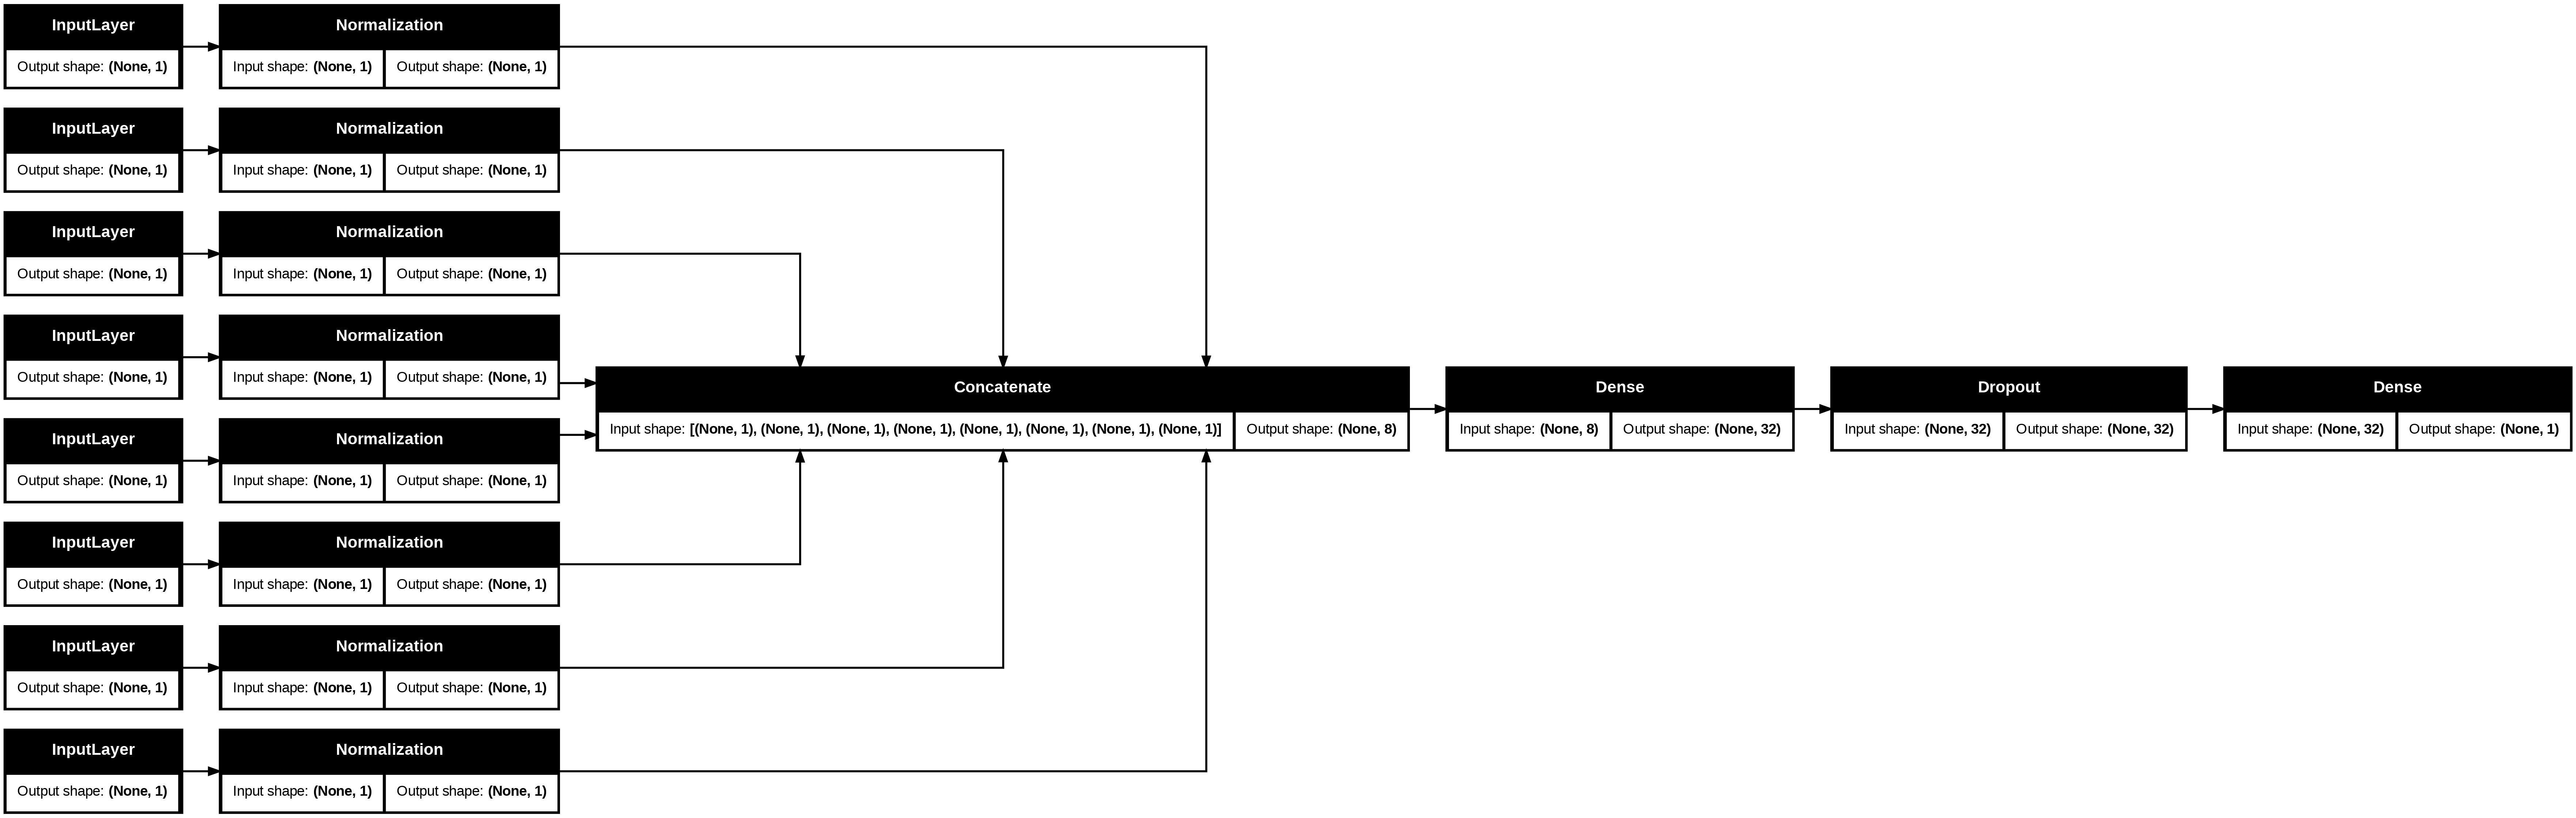

In [27]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.4538 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 2/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.4531 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 3/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.4533 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 4/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.4539 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 5/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.4535 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 6/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.4544 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 7/10
4440/4440 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.4540 - loss: nan - val_accuracy: 0.4531 - val_loss: nan
Epoch 8/10
